In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import csv

import numpy as np
import pickle
from scipy.stats import pearsonr

In [2]:
data = pd.read_csv('RFLFSODataFull.csv')
data = data[data['TemperatureDifference'] != data['TemperatureDifference'].max()]

In [3]:
Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = train_test_split(data, data["RFL_Att"],test_size=0.3, random_state=42)

train_rfl_fso = pd.DataFrame()
test_rfl_fso = pd.DataFrame()
train_rfl_fso["rfl_ori"] = Ytrain_rfl
train_rfl_fso["fso_ori"] = Xtrain_ori["FSO_Att"]
test_rfl_fso["rfl_ori"] = Yval_rfl
test_rfl_fso["fso_ori"] = Xval_ori["FSO_Att"]

Xtrain_rfl = Xtrain_ori.drop(columns=["RFL_Att","FSO_Att"])
Xval_rfl = Xval_ori.drop(columns=["RFL_Att","FSO_Att"])


In [4]:
rfl_rf_model = RandomForestRegressor(n_estimators=130, max_depth=25, min_samples_leaf=1, random_state=25,min_samples_split=2, oob_score=True, n_jobs=6)
fso_hybrid_rf_model = RandomForestRegressor(n_estimators = 150, max_depth=29, min_samples_leaf = 1, random_state = 25,min_samples_split =2, oob_score=True, n_jobs=6 )

fso_rf_model = RandomForestRegressor(n_estimators = 130, max_depth=30, min_samples_leaf = 1, random_state = 25,min_samples_split =2, oob_score=True, n_jobs=6 )
rfl_hybrid_rf_model = RandomForestRegressor(n_estimators=150, max_depth=26, min_samples_leaf=1, random_state=25,min_samples_split=2, oob_score=True, n_jobs=6)

# Method 1: From RF To FSO

In [5]:
rfl_rf_model.fit(Xtrain_rfl, Ytrain_rfl)

RandomForestRegressor(max_depth=25, n_estimators=130, n_jobs=6, oob_score=True,
                      random_state=25)

In [6]:
ytrain_rfl_pred = rfl_rf_model.predict(Xtrain_rfl)

In [7]:
train_rfl_mse = mean_squared_error(Ytrain_rfl, ytrain_rfl_pred)
train_rfl_rmse = np.sqrt(train_rfl_mse)
train_rfl_r2 = r2_score(Ytrain_rfl, ytrain_rfl_pred)

ytest_rfl_pred = rfl_rf_model.predict(Xval_rfl)

test_rfl_mse = mean_squared_error(Yval_rfl, ytest_rfl_pred)
test_rfl_rmse = np.sqrt(test_rfl_mse)
test_rfl_r2 = r2_score(Yval_rfl, ytest_rfl_pred)

print("RF RMSE (Train):", train_rfl_rmse)
print("RF RMSE (Test):", test_rfl_rmse)

print("RF R_Square (Train):", train_rfl_r2)
print("RF R_Square (Test):", test_rfl_r2)

RF RMSE (Train): 0.2019927573618222
RF RMSE (Test): 0.5288667387490041
RF R_Square (Train): 0.9965459979627637
RF R_Square (Test): 0.976406691220069


In [8]:
Xtrain_fso = Xtrain_rfl
Xtrain_fso['RFL_Att_pred'] = ytrain_rfl_pred
Ytrain_fso = train_rfl_fso["fso_ori"]
Xval_fso = Xval_rfl
Xval_fso['RFL_Att_pred'] = ytest_rfl_pred
Yval_fso = test_rfl_fso["fso_ori"]

In [ ]:
with open('hybrid_fso_second_model.pkl', 'rb') as file:
    fso_hybrid_rf_model = pickle.load(file)

ytrain_fso_pred = fso_hybrid_rf_model.predict(Xtrain_fso)
ytest_fso_pred = fso_hybrid_rf_model.predict(Xval_fso)

In [10]:
train_fso_mse = mean_squared_error(Ytrain_fso, ytrain_fso_pred)
train_fso_rmse = np.sqrt(train_fso_mse)
train_fso_r2 = r2_score(Ytrain_fso, ytrain_fso_pred)

test_fso_mse = mean_squared_error(Yval_fso, ytest_fso_pred)
test_fso_rmse = np.sqrt(test_fso_mse)
test_fso_r2 = r2_score(Yval_fso, ytest_fso_pred)

print("FSO RMSE (Train):", train_fso_rmse)
print("FSO RMSE (Test):", test_fso_rmse)
print("FSO R_Square (Train):", train_fso_r2)
print("FSO R_Square (Test):", test_fso_r2)

FSO RMSE (Train): 0.32106129710884435
FSO RMSE (Test): 0.8549547820281506
FSO R_Square (Train): 0.9932146922575303
FSO R_Square (Test): 0.9523893787470539


## Feature Importance

In [11]:
# sort important features
def sort_features(model,Xtrain,channel = "FSO",figure = False):
    
    feature_importance = model.feature_importances_
    feature_importance_dict = dict(zip(Xtrain.columns, feature_importance))
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)
    sorted_features= [x[0] for x in sorted_feature_importance]
    sorted_importance = [x[1] for x in sorted_feature_importance]

    if figure:
        plt.figure(figsize=(12, 9))
        bars = plt.barh(sorted_features, sorted_importance)
        for bar in bars:
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()*100:.1f}%', 
                    va='center', ha='left', fontsize=16, color='black')

        plt.xlabel('Feature Importance Ratio',fontsize=18)
        plt.ylabel('Features',fontsize=18)
        plt.title(f'Feature Importance of {channel} RF Model',fontsize=18)
        plt.tick_params(axis='both', labelsize=16)
        plt.show()
        
    return sorted_features, sorted_importance

In [ ]:
sorted_features_fso,sorted_importance_fso = sort_features(fso_hybrid_rf_model,Xtrain_fso,channel = "FSO",figure = False)

feature_importance = fso_hybrid_rf_model.feature_importances_

print("Feature Importance:", feature_importance)

Feature Importance: [1.98712247e-02 6.89699145e-03 6.22242623e-03 3.30954365e-01
 2.64842209e-04 3.43702867e-02 3.07378174e-02 6.16390388e-02
 1.12731224e-03 1.11860397e-03 1.08177887e-03 2.36990512e-02
 1.86886562e-03 7.92057782e-02 1.77204395e-02 2.17382031e-02
 3.89634595e-02 1.82296345e-02 1.40608294e-01 4.28474607e-02
 4.89674715e-02 2.55788462e-03 4.82929671e-03 9.77630867e-03
 5.01415832e-03 4.96890059e-02]


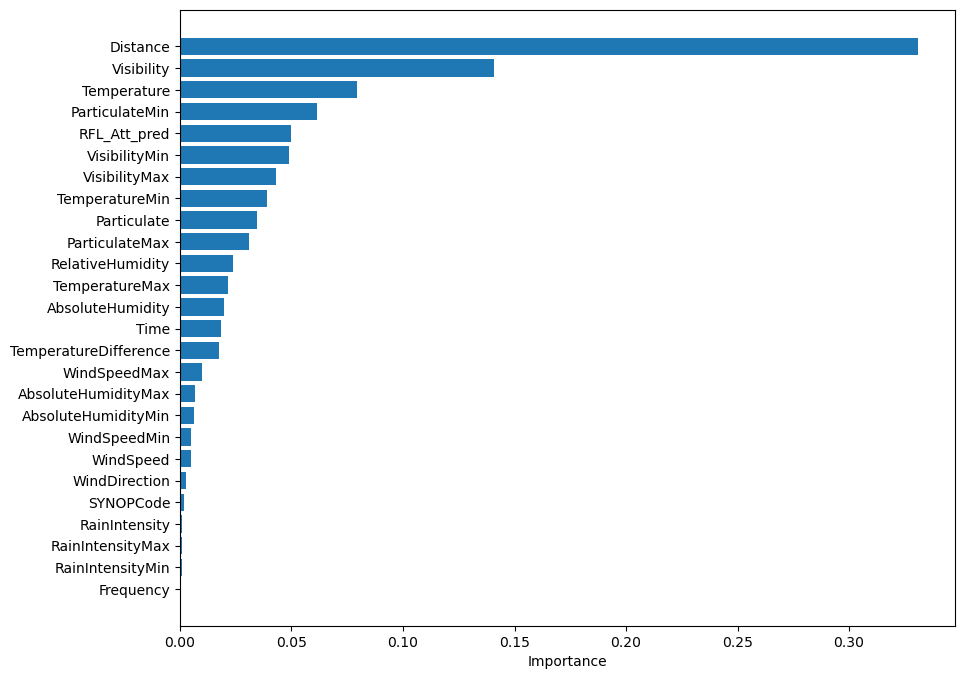

In [13]:
# plot the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': sorted_features_fso,
    'Importance': sorted_importance_fso
})

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.show()

## Feature Selection

In [14]:
def metrics_cal(model,Xtrain,Ytrain,Xval,Yval,oob = True):
    y_pred_train = model.predict(Xtrain)
    y_pred_val = model.predict(Xval)
    
    train_rmse = mean_squared_error(Ytrain, y_pred_train, squared=False)
    val_rmse = mean_squared_error(Yval, y_pred_val, squared=False)
    print("Training RMSE:", train_rmse)
    print("Validation RMSE:", val_rmse)

    train_r2 = r2_score(Ytrain, y_pred_train)
    val_r2 = r2_score(Yval, y_pred_val)
    print("Train R²:", train_r2)
    print("Validation R²:", val_r2)
    
    if oob:
        oob_r2 = model.oob_score_
        print("OOB R²:", oob_r2)
    else:
        oob_r2 = None

    return train_rmse, train_r2,val_rmse,val_r2,oob_r2

In [15]:
def oob_info(model,Xtrain,Ytrain,Xval,Yval,channel = "FSO"):
    
    performance_scores = []
    for i in range(len(Xtrain.columns)+1):
        if i == 0:
            model.fit(Xtrain, Ytrain)
            sorted_features, sorted_importance = \
                sort_features(model,Xtrain,channel = "FSO",figure = False)
            train_rmse, train_r2,val_rmse,val_r2,oob_r2= \
                metrics_cal(model,Xtrain,Ytrain,Xval,Yval,oob = True)
        else:
            remove_feature = sorted_features[0]
            features_list =  sorted_features[1::] 
            print(i,remove_feature,features_list) 

            if remove_feature and len(features_list) >= 1:
                model.fit(Xtrain[features_list], Ytrain)
                
                sorted_features, sorted_importance = \
                    sort_features(model,Xtrain[features_list] ,channel = "FSO",figure = False)
                train_rmse, train_r2,val_rmse,val_r2,oob_r2= \
                    metrics_cal(model,Xtrain[features_list],Ytrain,Xval[features_list],Yval,oob = True)
        
        if i == 0:
            performance_scores.append(("All Features",train_rmse, train_r2,val_rmse,val_r2, oob_r2,sorted_features[0],sorted_importance[0]))
        else:
            performance_scores.append((remove_feature,train_rmse, train_r2,val_rmse,val_r2, oob_r2,sorted_features[0],sorted_importance[0]))
    
    
    return performance_scores

In [ ]:
performance_scores = oob_info(fso_hybrid_rf_model,Xtrain_fso,Ytrain_fso,Xval_fso,Yval_fso,channel = "FSO")

important_columns = ["remove_feature", "train_rmse", "train_r2","val_rmse","val_r2", "oob_r2","next_remove","importance_score"]
df = pd.DataFrame(performance_scores, columns=important_columns)
file_name = "FSO_hybrid_feature_importance_wrapple.csv"
df.to_csv(file_name, index=False) 

In [17]:
abbr = {'All Features': 'All',
        'WindDirection': 'Wind_Direction',
        'WindSpeed': 'Wind_Speed',
        'WindSpeedMin': 'Wind_Spped_Min',
        'ParticulateMin': 'Part_Min',
        'WindSpeedMax': 'Wind_Spped_Max',
        'TemperatureMin': 'Temp_Min',
        'TemperatureMax': 'Temp_Max',
        'Particulate': 'Part_Count',
        'VisibilityMin': 'Visibility_Min',
        'AbsoluteHumidityMax': 'AH_Max',
        'TemperatureDifference': 'Temp_Diff',
        'AbsoluteHumidityMin': 'AH_Min',
        'Time': 'Hour',
        'VisibilityMax': 'Visibility_Max',
        'Frequency': 'Freq',
        'RelativeHumidity': 'RH',
        'ParticulateMax': 'Part_Max',
        'Visibility': 'Visibility',
        'SYNOPCode': 'SC',
        'Temperature': 'Temp',
        'RainIntensityMin': 'RI_Min',
        'RainIntensityMax': 'RI_Max',
        'Distance': 'Dist',
        'RainIntensity': 'RI',
        'AbsoluteHumidity': 'AH'}

In [18]:
def plot_feature_importance_code(df, code=0, cut="VisibilityMin", channel="FSO", markersize=10, legend_loc="lower left", legend_loc1="upper left",legend_valid=0, legend_x1=0.2, legend_y1=0.4, legend_x2=0.5, legend_y2=0.4):
    
    df["remove_feature"] = df["remove_feature"].map(abbr).fillna(df["remove_feature"])
    df["remove_feature"] = df["remove_feature"].astype(str)  # Ensure all values are strings

    # Extract columns
    remove_features = df["remove_feature"]
    val_rmse = df["val_rmse"]
    oob_r2 = df["oob_r2"]

    # Ensure threshold exists
    if cut not in remove_features.values:
        print("Cut line not found")
        index = None
    else:
        index = remove_features.tolist().index(cut)

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax2 = ax1.twinx()

    ax1.plot(remove_features, val_rmse, markersize=markersize, color='blue', label="test_rmse")
    ax2.plot(remove_features, oob_r2, markersize=markersize, color='orange', label="oob_r2")

    ax1.grid(True)
    
    if index is not None:
        ax1.axvline(x=index, color='green', linestyle='--')

    ax1.set_ylabel('RMSE (dB)', fontsize=20, color='b')
    ax1.tick_params(axis='y', labelsize=18, colors='b')
    
    ax2.set_ylabel('RSquare', fontsize=20, color='orange')
    ax2.tick_params(axis='y', labelsize=18, colors='orange')

    ax1.set_xticklabels(remove_features, rotation=80, fontsize=20)

    plt.tight_layout()
    plt.show()
    return fig


C:\Users\Tina Qi\AppData\Local\Temp\ipykernel_14968\3196328434.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(remove_features, rotation=80, fontsize=20)


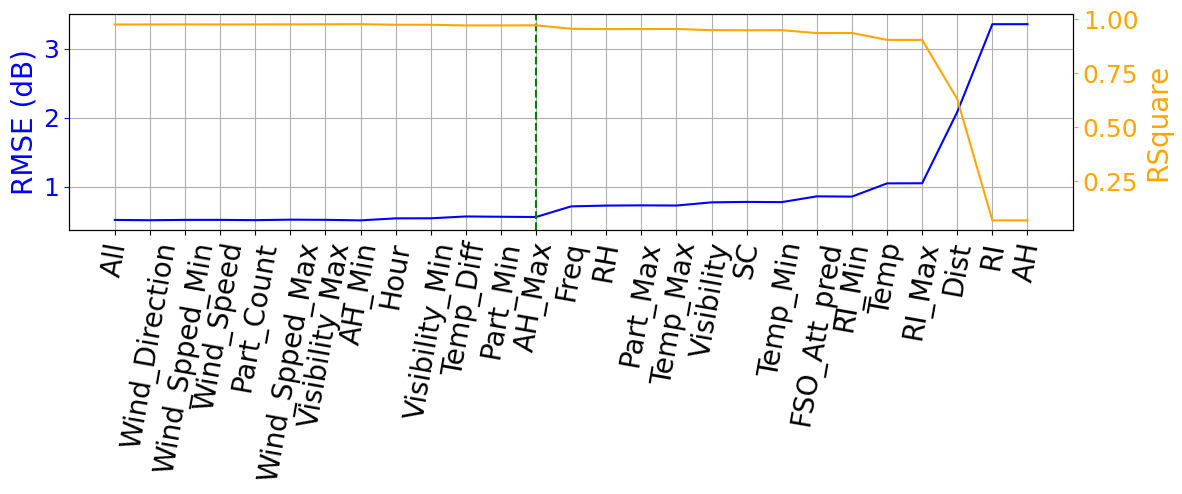

In [19]:
df= pd.read_csv("rfl_hybrid_feature_importance_wrapple.csv")
fig_RF= plot_feature_importance_code(df, code = 9,cut="AH_Max", channel="RFL", markersize=10, legend_loc="center left", legend_loc1="center")

# Method 2: From FSO To RF

In [20]:
Xtrain_fso = Xtrain_ori.drop(columns=["RFL_Att","FSO_Att"])
Xval_fso = Xval_ori.drop(columns=["RFL_Att","FSO_Att"])

Ytrain_fso = train_rfl_fso["fso_ori"]
Yval_fso = test_rfl_fso["fso_ori"]

In [21]:
fso_rf_model.fit(Xtrain_fso, Ytrain_fso)

RandomForestRegressor(max_depth=30, n_estimators=130, n_jobs=6, oob_score=True,
                      random_state=25)

In [22]:
ytrain_fso_pred = fso_rf_model.predict(Xtrain_fso)

In [23]:
train_fso_mse = mean_squared_error(Ytrain_fso, ytrain_fso_pred)
train_fso_rmse = np.sqrt(train_fso_mse)
train_fso_r2 = r2_score(Ytrain_fso, ytrain_fso_pred)

# Calculate predictions on validation set
ytest_fso_pred = fso_rf_model.predict(Xval_fso)

# Calculate MSE and R2 on validation set
test_fso_mse = mean_squared_error(Yval_fso, ytest_fso_pred)
test_fso_rmse = np.sqrt(test_fso_mse)
test_fso_r2 = r2_score(Yval_fso, ytest_fso_pred)

print("FSO RMSE (Train):", train_fso_rmse)
print("FSO RMSE (Test):", test_fso_rmse)
print("FSO R_Square (Train):", train_fso_r2)
print("FSO R_Square (Test):", test_fso_r2)


FSO RMSE (Train): 0.31330495993807134
FSO RMSE (Test): 0.8284426515498833
FSO R_Square (Train): 0.9935385769267132
FSO R_Square (Test): 0.9552964042783997


In [24]:
Xtrain_rfl = Xtrain_fso
Xtrain_rfl['FSO_Att_pred'] = ytrain_fso_pred
Ytrain_rfl = train_rfl_fso["rfl_ori"]
Xval_rfl = Xval_fso
Xval_fso['FSO_Att_pred'] = ytest_fso_pred
Yval_fso = test_rfl_fso["rfl_ori"]

In [ ]:
with open('hybrid_rfl_second_model.pkl', 'rb') as file:
    rfl_hybrid_rf_model = pickle.load(file)
    
ytrain_rfl_pred = rfl_hybrid_rf_model.predict(Xtrain_rfl)
ytest_rfl_pred = rfl_hybrid_rf_model.predict(Xval_rfl)

In [26]:
train_rfl_mse = mean_squared_error(Ytrain_rfl, ytrain_rfl_pred)
train_rfl_rmse = np.sqrt(train_rfl_mse)
train_rfl_r2 = r2_score(Ytrain_rfl, ytrain_rfl_pred)

# Calculate MSE and R2 on validation set
test_rfl_mse = mean_squared_error(Yval_rfl, ytest_rfl_pred)
test_rfl_rmse = np.sqrt(test_rfl_mse)
test_rfl_r2 = r2_score(Yval_rfl, ytest_rfl_pred)

print("RF RMSE (Train):", train_rfl_rmse)
print("RF RMSE (Test):", test_rfl_rmse)
print("RF R_Square (Train):", train_rfl_r2)
print("RF R_Square (Test):", test_rfl_r2)

RF RMSE (Train): 0.1962081167084169
RF RMSE (Test): 0.5209297343491684
RF R_Square (Train): 0.9967409957074408
RF R_Square (Test): 0.9771095338144877


## Feature Importance

In [ ]:
sorted_features_fso,sorted_importance_fso = sort_features(rfl_hybrid_rf_model,Xtrain_fso,channel = "RFL",figure = False)

feature_importance = rfl_hybrid_rf_model.feature_importances_

print("Feature Importance:", feature_importance)

Feature Importance: [0.19171484 0.00676167 0.0051055  0.13775271 0.01160265 0.00242771
 0.0077212  0.00688894 0.22667631 0.0721265  0.07777173 0.01159711
 0.03344916 0.08387295 0.0060314  0.01752622 0.02973525 0.00542736
 0.0064149  0.0037924  0.00543521 0.00092197 0.00114959 0.00216333
 0.00092473 0.04500865]


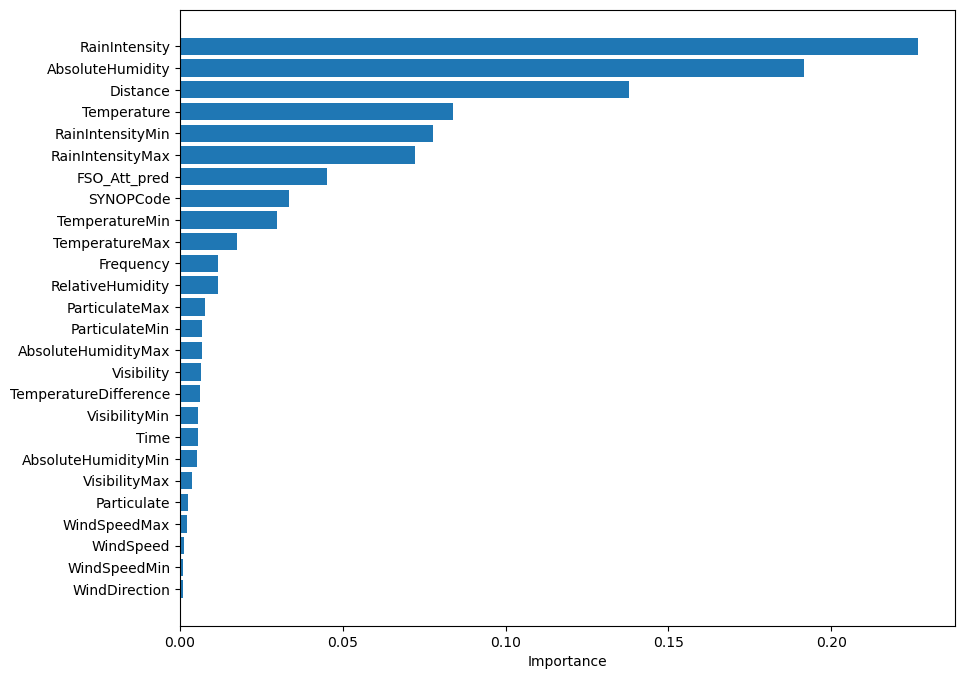

In [31]:
# plot the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': sorted_features_fso,
    'Importance': sorted_importance_fso
})

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.show()

## Feature Selection

In [ ]:
performance_scores = oob_info(rfl_hybrid_rf_model,Xtrain_fso,Ytrain_fso,Xval_fso,Yval_fso,channel = "RFL")

important_columns = ["remove_feature", "train_rmse", "train_r2","val_rmse","val_r2", "oob_r2","next_remove","importance_score"]
df = pd.DataFrame(performance_scores, columns=important_columns)
file_name = "rfl_hybrid_feature_importance_wrapple.csv"
df.to_csv(file_name, index=False) 

C:\Users\Tina Qi\AppData\Local\Temp\ipykernel_14968\3196328434.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(remove_features, rotation=80, fontsize=20)


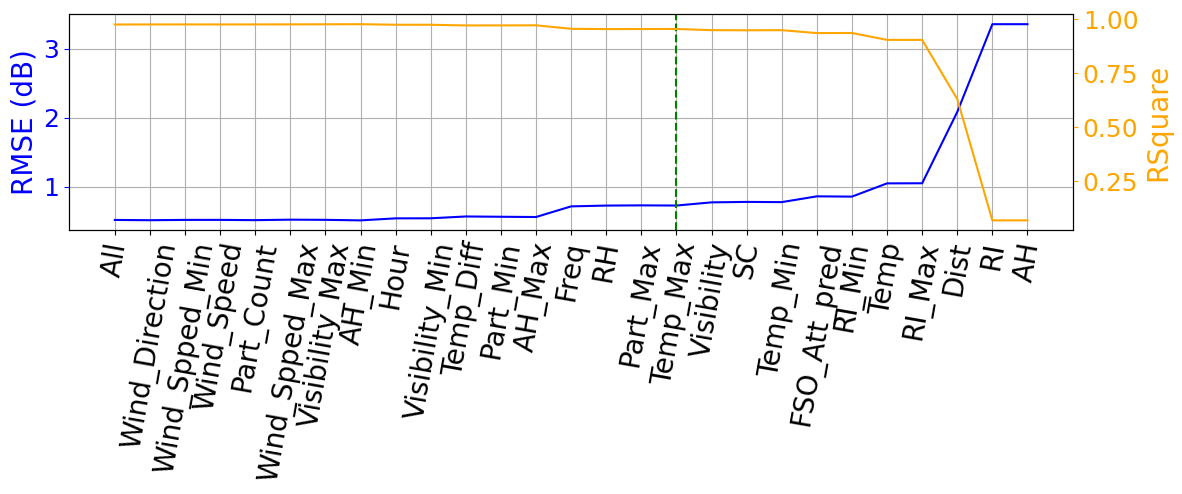

In [32]:
df = pd.read_csv("rfl_hybrid_feature_importance_wrapple.csv")
fig_FSO= plot_feature_importance_code(df, code = 9,cut="Temp_Max", channel="FSO",markersize=10, legend_loc="center left", legend_loc1="center",legend_valid = 1,legend_x1 = 0.1,legend_y1= 0.5,legend_x2=0.3, legend_y2=0.5)

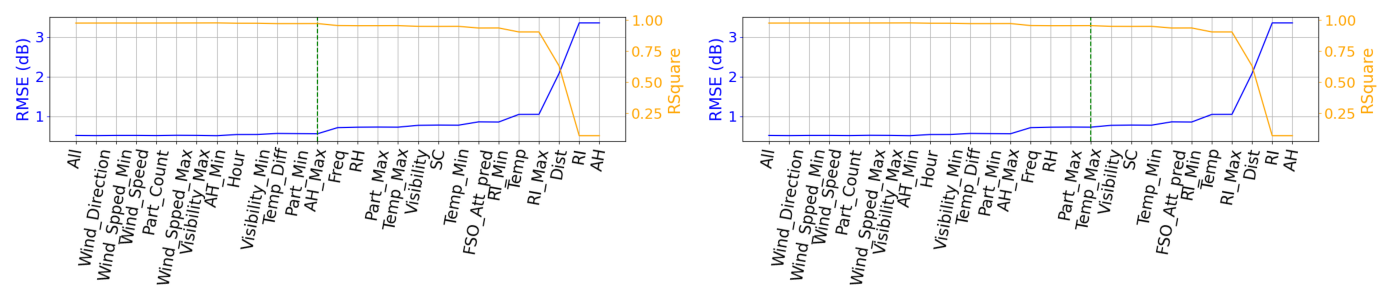

In [ ]:
# Combine them togehter
fig = plt.figure(figsize=(14, 6)) 

ax1 = fig.add_subplot(1, 2, 1)  
ax1.imshow(fig_RF.canvas.renderer.buffer_rgba(), extent=[0, fig_RF.canvas.renderer.width, 0, fig_RF.canvas.renderer.height])
ax1.set_axis_off()  

ax2 = fig.add_subplot(1, 2, 2)  
ax2.imshow(fig_FSO.canvas.renderer.buffer_rgba(), extent=[0, fig_FSO.canvas.renderer.width, 0, fig_FSO.canvas.renderer.height])
ax2.set_axis_off()  

plt.tight_layout()
plt.show()

# PCC

In [56]:
# collect the data
train_rfl_fso_summary = train_rfl_fso
train_rfl_fso_summary["rfl_1st"] = ytrain_rfl_pred
train_rfl_fso_summary["fso_2nd"] = ytrain_fso_pred

test_rfl_fso_summary = test_rfl_fso
test_rfl_fso_summary["rfl_1st"] = ytest_rfl_pred
test_rfl_fso_summary["fso_2nd"] = ytest_fso_pred

train_rfl_fso_summary["fso_1st"] = ytrain_fso_pred
train_rfl_fso_summary["rfl_2nd"] = ytrain_rfl_pred

test_rfl_fso_summary["rfl_2nd"] = ytest_rfl_pred
test_rfl_fso_summary["fso_1st"] = ytest_fso_pred

print(train_rfl_fso_summary.head(5))
print(test_rfl_fso_summary.head(5))

         rfl_ori   fso_ori    rfl_1st   fso_2nd   fso_1st    rfl_2nd  \
12120   4.346394  8.501193   4.356895  8.517289  8.517289   4.356895   
12396   6.437583  8.073308   6.253927  7.533465  7.533465   6.253927   
45768  11.700958  2.876168  11.723141  2.840728  2.840728  11.723141   
38733  11.410279  2.538526  11.355499  2.671579  2.671579  11.355499   
79697  11.600878  7.997360  11.604806  8.180989  8.180989  11.604806   

       SYNOPcode  
12120          0  
12396          0  
45768          0  
38733          0  
79697          0  
         rfl_ori    fso_ori    rfl_1st    fso_2nd    rfl_2nd    fso_1st  \
23812  12.025320   3.446932  11.984991   3.343739  11.984991   3.343739   
33249  12.537385   4.029149  12.448155   3.389689  12.448155   3.389689   
31945  15.971561   5.697896  15.875087   5.766119  15.875087   5.766119   
3432   11.351910  12.156028  11.320538  11.833751  11.320538  11.833751   
64008  11.849080   8.374321  11.871727   7.088551  11.871727   7.088551   

  

In [57]:
# calculate PCC
correlation_coefficient, p_value = pearsonr(train_rfl_fso_summary["rfl_ori"], train_rfl_fso_summary["fso_ori"])
correlation_coefficient1, p_value1 = pearsonr(train_rfl_fso_summary["rfl_1st"], train_rfl_fso_summary["fso_2nd"])
correlation_coefficient2, p_value2 = pearsonr(train_rfl_fso_summary["rfl_2nd"], train_rfl_fso_summary["fso_1st"])

In [58]:
# SYNOPCode
indices = data.groupby('SYNOPCode').apply(lambda x: x.index.tolist()).to_dict()

synopcode = [synop_code for i in train_rfl_fso_summary.index for synop_code, index_list in indices.items() if i in index_list]
train_rfl_fso_summary["SYNOPcode"] = synopcode

synopcode1 = [synop_code for i in test_rfl_fso_summary.index for synop_code, index_list in indices.items() if i in index_list]
test_rfl_fso_summary["SYNOPcode"] = synopcode1

In [60]:
# Method 1
correlation_coefficient, p_value = pearsonr(train_rfl_fso_summary["rfl_ori"], train_rfl_fso_summary["fso_ori"])
correlation_coefficient, p_value = pearsonr(train_rfl_fso_summary["rfl_1st"], train_rfl_fso_summary["fso_2nd"])
correlation_coefficient, p_value = pearsonr(train_rfl_fso_summary["rfl_2nd"], train_rfl_fso_summary["fso_1st"])
print(f"SYNOPCode=all: 0={correlation_coefficient},1={correlation_coefficient1},2={correlation_coefficient2}")
grouped = train_rfl_fso_summary.groupby('SYNOPcode')
for name, group in grouped:
    correlation_coefficient, p_value = pearsonr(group["rfl_ori"], group["fso_ori"])
    correlation_coefficient1, p_value1 = pearsonr(group["rfl_1st"], group["fso_2nd"])
    correlation_coefficient2, p_value2 = pearsonr(group["rfl_2nd"], group["fso_1st"])
    print(f"SYNOPCode={name}: 0={correlation_coefficient},1={correlation_coefficient1},2={correlation_coefficient2}")

SYNOPCode=all: 0=0.08851365197224353,1=-0.17602161093742602,2=-0.17602161093742602
SYNOPCode=0: 0=-0.2651251516329542,1=-0.2753926123514098,2=-0.2753926123514098
SYNOPCode=3: 0=-0.3893227693996098,1=-0.4104248221932327,2=-0.4104248221932327
SYNOPCode=4: 0=0.5803599389629717,1=0.5867651200600448,2=0.5867651200600448
SYNOPCode=5: 0=-0.1457299165389345,1=-0.15521775660700315,2=-0.15521775660700315
SYNOPCode=6: 0=0.34641557583008026,1=0.35100950463798747,2=0.35100950463798747
SYNOPCode=7: 0=0.793984007816284,1=0.7979024498354552,2=0.7979024498354552
SYNOPCode=8: 0=-0.15524031464932236,1=-0.17602161093742602,2=-0.17602161093742602


In [ ]:
# Method 2
correlation_coefficient, p_value = pearsonr(test_rfl_fso_summary["rfl_ori"], test_rfl_fso_summary["fso_ori"])
correlation_coefficient, p_value = pearsonr(test_rfl_fso_summary["rfl_1st"], test_rfl_fso_summary["fso_2nd"])
correlation_coefficient, p_value = pearsonr(test_rfl_fso_summary["rfl_2nd"], test_rfl_fso_summary["fso_1st"])
print(f"SYNOPCode=all: 0={correlation_coefficient},1={correlation_coefficient1},2={correlation_coefficient2}")
grouped = test_rfl_fso_summary.groupby('SYNOPcode')
for name, group in grouped:
    correlation_coefficient, p_value = pearsonr(group["rfl_ori"], group["fso_ori"])
    correlation_coefficient1, p_value1 = pearsonr(group["rfl_1st"], group["fso_2nd"])
    correlation_coefficient2, p_value2 = pearsonr(group["rfl_2nd"], group["fso_1st"])
    print(f"SYNOPCode={name}: 0={correlation_coefficient},1={correlation_coefficient1},2={correlation_coefficient2}")

SYNOPCode=all: 0=0.09169467229698973,1=-0.17602161093742602,2=-0.17602161093742602
SYNOPCode=0: 0=-0.2737165269161815,1=-0.2957847777931439,2=-0.2957847777931439
SYNOPCode=3: 0=-0.5064920334238934,1=-0.5272643973626322,2=-0.5272643973626322
SYNOPCode=4: 0=0.5793198591828581,1=0.6064147297605671,2=0.6064147297605671
SYNOPCode=5: 0=-0.18097786523330195,1=-0.19162166424232385,2=-0.19162166424232385
SYNOPCode=6: 0=0.35267236366681154,1=0.3626780536321769,2=0.3626780536321769
SYNOPCode=7: 0=0.8209942493146418,1=0.8022555370295588,2=0.8022555370295588
SYNOPCode=8: 0=-0.20323931464794368,1=-0.25306284995262107,2=-0.25306284995262107


In [69]:
SYNOPCode = ['All', 'Clear', 'Dust', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Shower']

method1 = {'All': [0.08851365197224352,0.08832623505727862,0.08851365197224352],
           'Clear': [-0.2651251516329542,-0.2758552657472954,-0.2753926123514098],
           'Dust': [-0.3893227693996098,-0.41264163214485894,-0.4104248221932327],
           'Fog': [0.5803599389629717,0.5857111210938928,0.5867651200600448],
           'Drizzle': [-0.1457299165389345,-0.15589423388272838,-0.15521775660700313],
           'Rain': [0.34641557583008026,0.35033499886778474,0.35100950463798747],
           'Snow': [0.793984007816284,0.7975173258193008,0.7979024498354552],
           'Shower': [-0.15524031464932236,-0.1787823144242655,-0.17602161093742602]}

method2 = {'All': [0.09169467229698972,-0.1787823144242655,-0.17602161093742602],
           'Clear': [-0.2737165269161815,-0.29656536968853736,-0.2957847777931439],
           'Dust': [-0.5064920334238934,-0.5435558953249375,-0.5272643973626319],
           'Fog': [0.5793198591828581,0.6041873229880543,0.6064147297605671],
           'Drizzle': [-0.18097786523330195,-0.1928444062947235,-0.19162166424232382],
           'Rain': [0.35267236366681154,0.36312217957181175,0.3626780536321769],
           'Snow': [0.8209942493146418,0.8031691066770094,0.8022555370295588],
           'Shower': [-0.20323931464794368,-0.2527236196037194,-0.25306284995262107]}

In [70]:
# extract values
method1_0 = [method1[synop][0] for synop in SYNOPCode]
method1_1 = [method1[synop][1] for synop in SYNOPCode]
method1_2 = [method1[synop][2] for synop in SYNOPCode]

method2_0 = [method2[synop][0] for synop in SYNOPCode]
method2_1 = [method2[synop][1] for synop in SYNOPCode]
method2_2 = [method2[synop][2] for synop in SYNOPCode]

In [ ]:
# PCC output
r_1 = [format(x, ".4f") for x in method2_1]
print(", ".join(r_1))

r_2 = [format(x, ".4f") for x in method2_2]
print(", ".join(r_2))

-0.1788, -0.2966, -0.5436, 0.6042, -0.1928, 0.3631, 0.8032, -0.2527
-0.1760, -0.2958, -0.5273, 0.6064, -0.1916, 0.3627, 0.8023, -0.2531


In [ ]:
#r_1 - r_2
r_1 = np.array([-0.1788, -0.2966, -0.5436, 0.6042, -0.1928, 0.3631, 0.8032, -0.2527])
r_2 = np.array([-0.1760, -0.2958, -0.5273, 0.6064, -0.1916, 0.3627, 0.8023, -0.2531])

r_diff = r_1 - r_2
print(r_diff)

[-0.0028 -0.0008 -0.0163 -0.0022 -0.0012  0.0004  0.0009  0.0004]


# MI

In [71]:
method2_2_p = [0, 0, 0.6064147297605671, 0, 0.3626780536321769, 0.8022555370295588, 0]
method2_2_n = [-0.2957847777931439, -0.5272643973626319, 0, -0.19162166424232382, 0, 0, -0.25306284995262107]


C:\Users\Tina Qi\AppData\Local\Temp\ipykernel_14968\3863485864.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(synop_codes, rotation=0, fontsize=14)  # Ensure proper display order


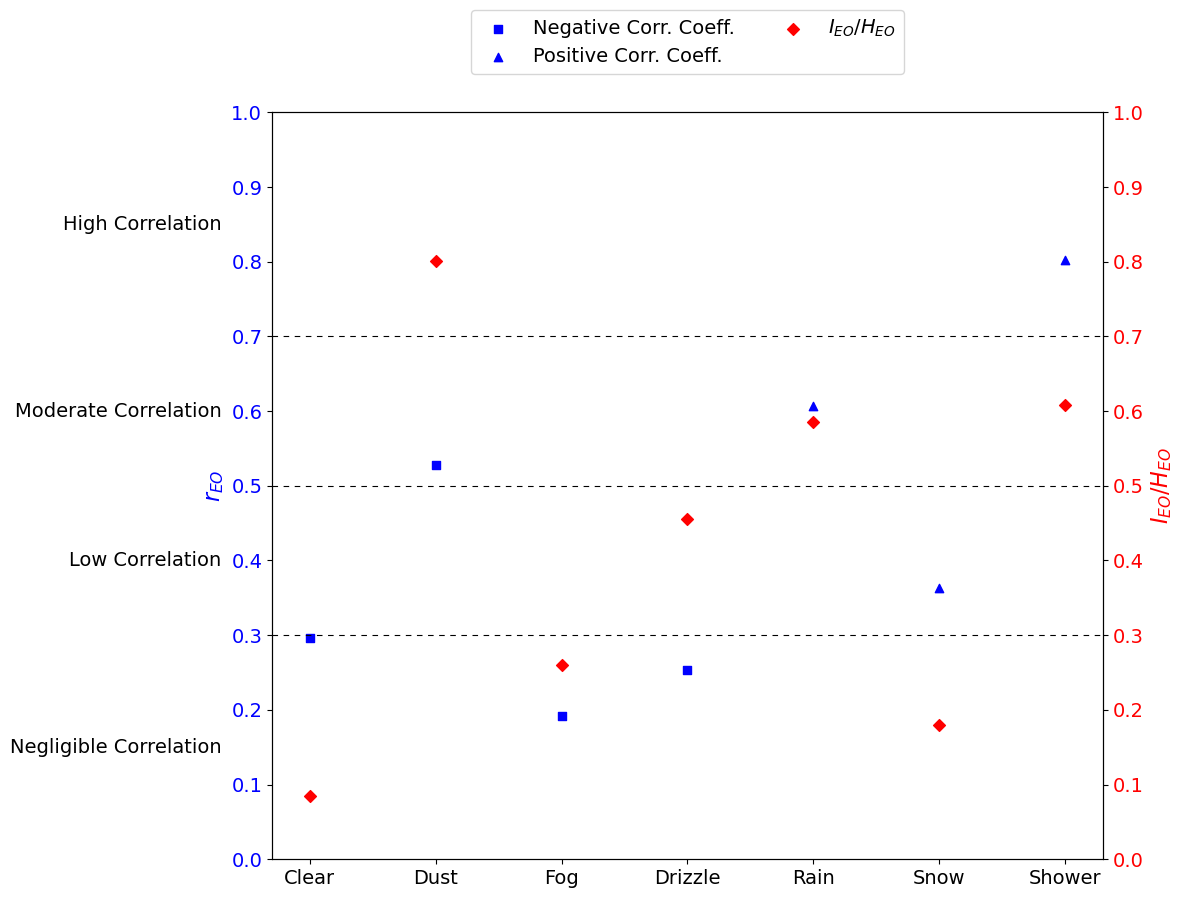

In [ ]:
method2_2_new = [0.08464552377441116, 0.8007520447053911, 0.5855902408073715, 0.2597455875812495, 0.17935105005591245, 0.6082576111539809, 0.45588815851890807]

# ensure SYNOPCode in correct order
synop_codes = pd.Categorical(SYNOPCode, categories=SYNOPCode, ordered=True)

fig, ax3 = plt.subplots(figsize=(12, 9))

# Plot negative and positive corr coef
for i, value in enumerate(method2_2_n):
    if value < 0:
        ax3.scatter(SYNOPCode[i], abs(value), color='blue', marker='s', label='Negative Corr. Coeff.' if i == 0 else "")
for i, value in enumerate(method2_2_p):
    if value > 0:
        ax3.scatter(SYNOPCode[i], value, color='blue', marker='^', label='Positive Corr. Coeff.' if i == 2 else "")

ax3.set_ylabel('$r_{EO}$', color='blue', fontsize=16)
ax3.tick_params(axis='y', labelcolor='blue', labelsize=14)

# Set the range for r_eo (0 to 1 with 0.1 intervals)
ax3.set_ylim(0, 1)
ax3.set_yticks([i * 0.1 for i in range(11)])

ax3.tick_params(axis='x', labelsize=14)  
ax3.set_xticklabels(SYNOPCode, rotation=0, fontsize=14)  

ax4 = ax3.twinx()
ax4.set_ylabel('$I_{EO}/H_{EO}$', color='red', fontsize=16)
ax4.tick_params(axis='y', labelcolor='red', labelsize=14)

ax4.set_ylim(0, 1)
ax4.set_yticks([i * 0.1 for i in range(11)])

# Plot I_{EO}/H_{EO}
ax4.scatter(SYNOPCode, method2_2_new, color='red', marker='D', label='$I_{EO}/H_{EO}$')

# Add interpretation line for correlation
ax3.axhline(0.3, color='black', linestyle=(0, (5, 5)), linewidth=0.8)
ax3.axhline(0.5, color='black', linestyle=(0, (5, 5)), linewidth=0.8)
ax3.axhline(0.7, color='black', linestyle=(0, (5, 5)), linewidth=0.8)

# Add annotations
ax3.text(-0.7, 0.85, 'High Correlation', color='black', fontsize=14, va='center', ha='right')
ax3.text(-0.7, 0.6, 'Moderate Correlation', color='black', fontsize=14, va='center', ha='right')
ax3.text(-0.7, 0.4, 'Low Correlation', color='black', fontsize=14, va='center', ha='right')
ax3.text(-0.7, 0.15, 'Negligible Correlation', color='black', fontsize=14, va='center', ha='right')

# add legend
handles1, labels1 = ax3.get_legend_handles_labels()
handles2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)


fig.tight_layout()
plt.show()


# Heatmap

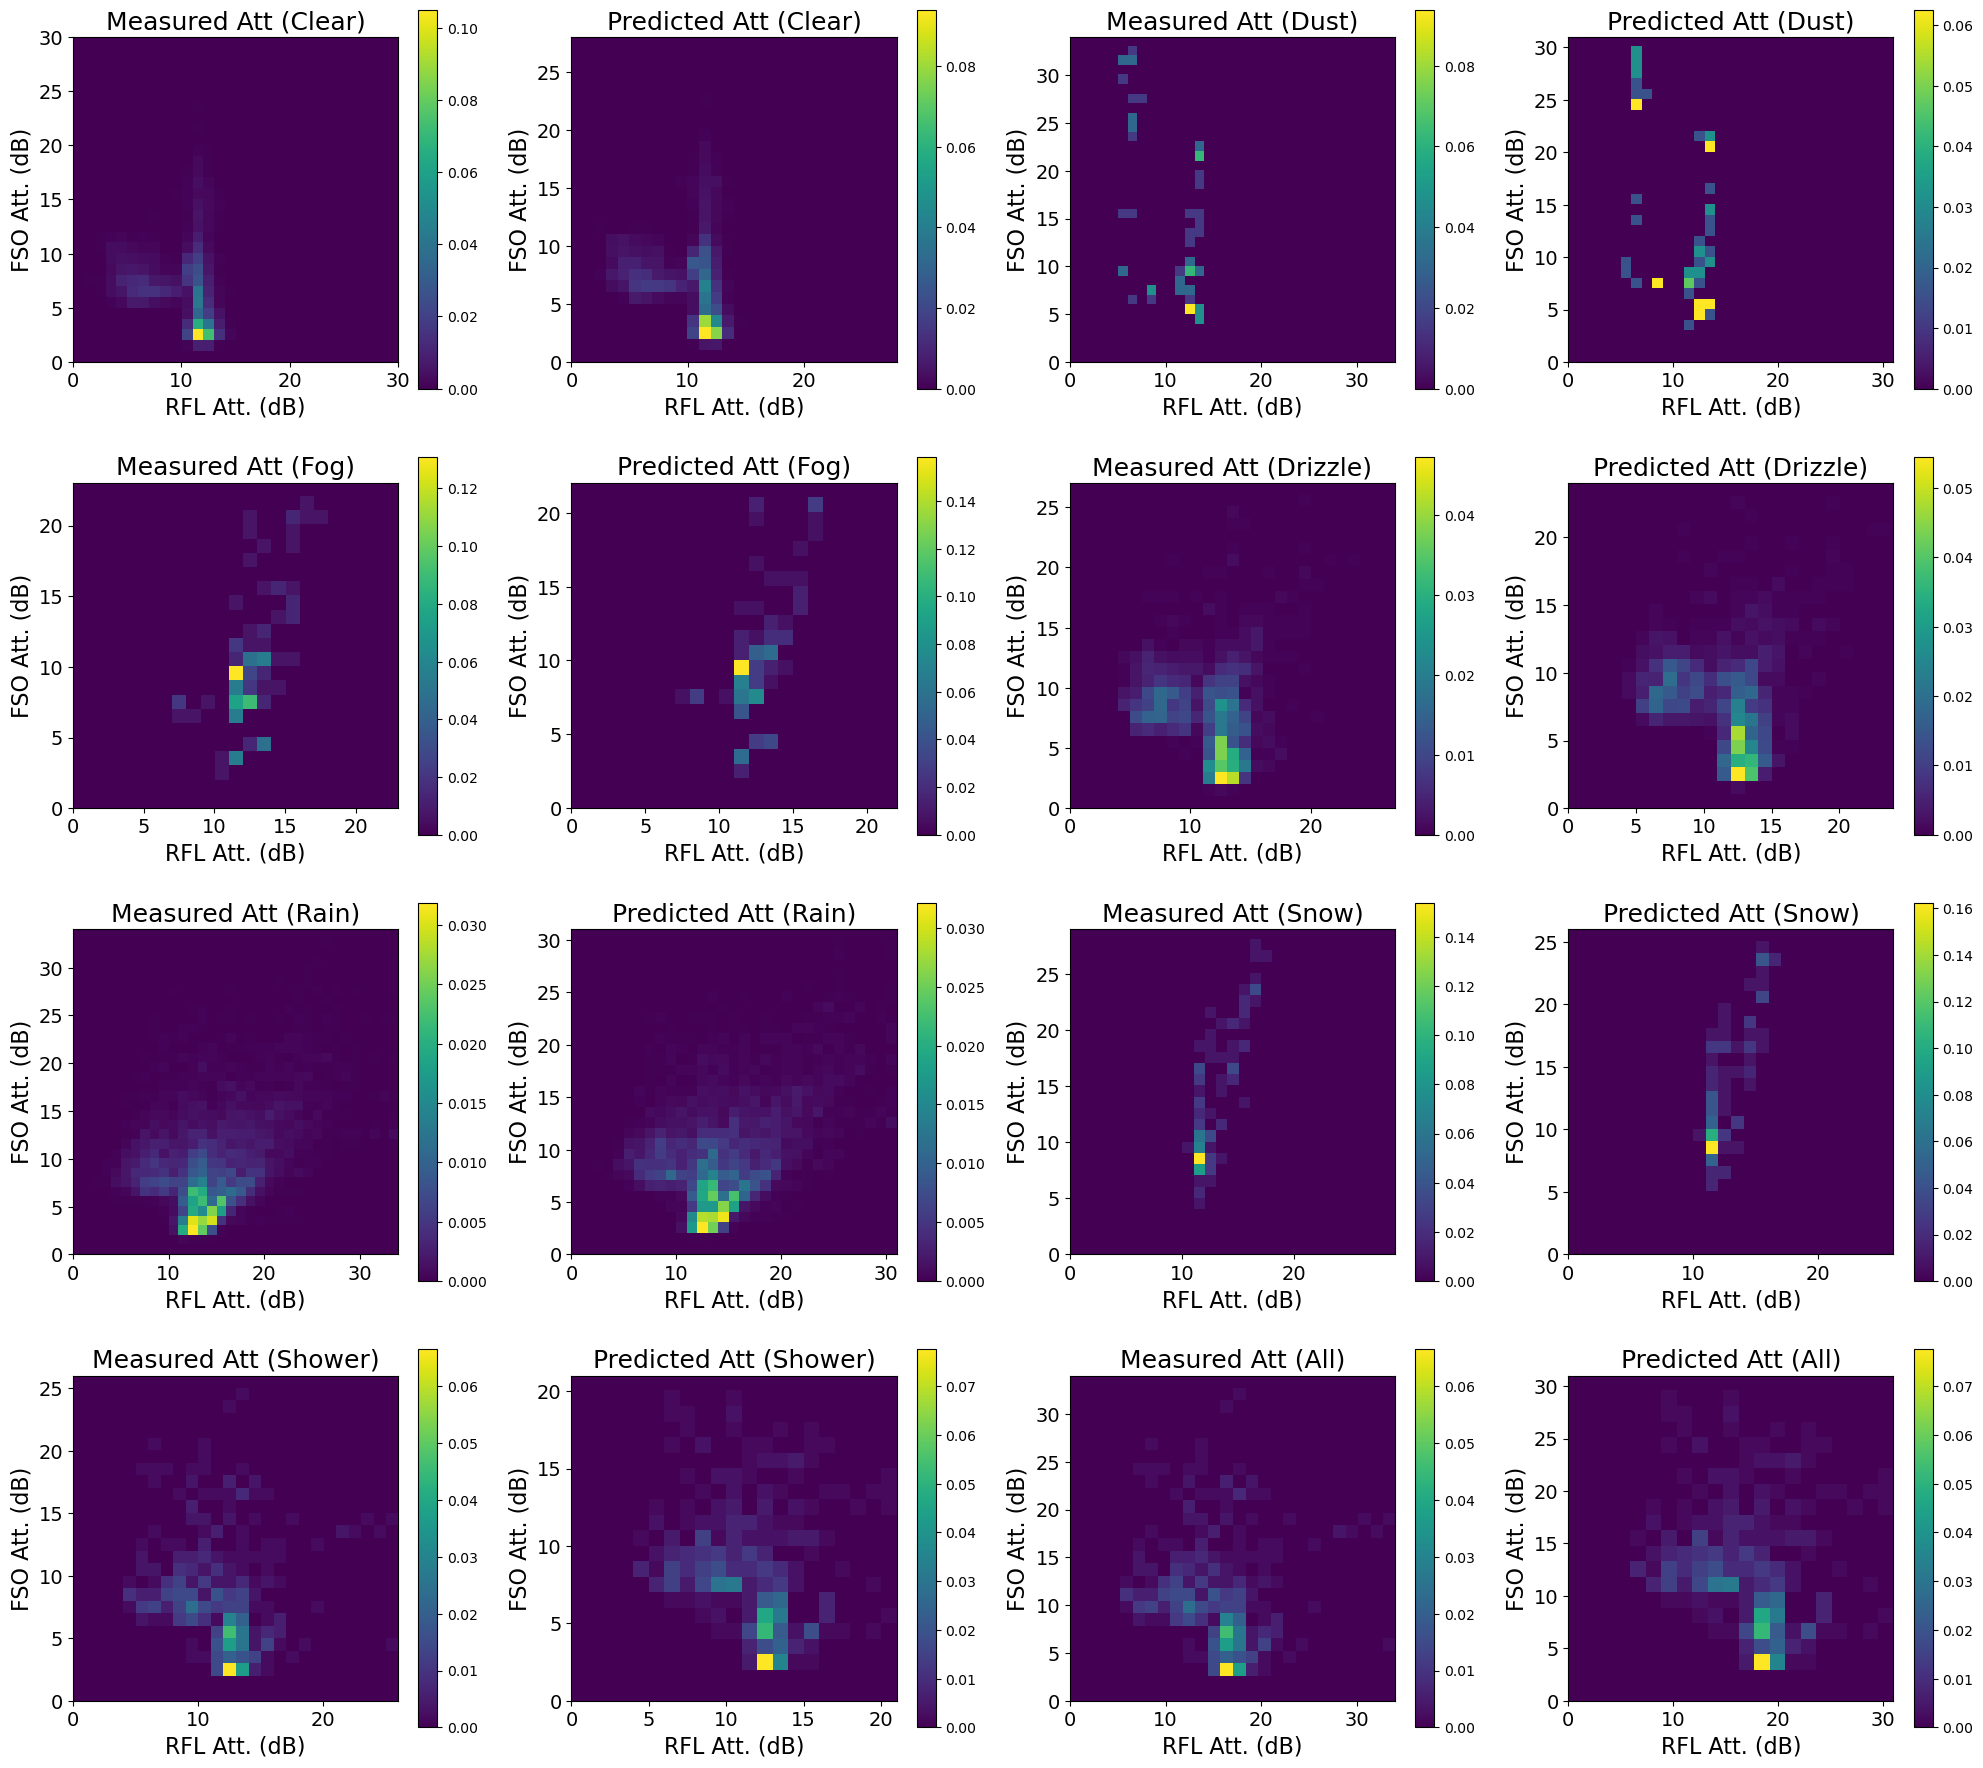

In [ ]:
def bin_set(d1,d2,interval = 0.1):
    bin_min = 0
    bin_max = max(d2.max(), d2.max())
    bins = np.arange(bin_min, bin_max + interval, interval)
    return bins

data = test_rfl_fso_summary
correlation_matrix = data.groupby(['SYNOPcode'])

synopcodes = ['Clear', 'Dust', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Shower']

plt.figure(figsize=(20, 18))

count = 1
interval = 1

for idx, (group_name, group_data) in enumerate(correlation_matrix):
    rfl_ori_digitize = np.digitize(group_data["rfl_ori"], 
                                     bin_set(group_data["rfl_ori"], group_data["fso_ori"], interval))
    fso_ori_digitize = np.digitize(group_data["fso_ori"], 
                                     bin_set(group_data["rfl_ori"], group_data["fso_ori"], interval))

    rfl_1st_digitize = np.digitize(group_data["rfl_1st"], 
                                     bin_set(group_data["rfl_1st"], group_data["fso_2nd"], interval))
    fso_2nd_digitize = np.digitize(group_data["fso_2nd"], 
                                     bin_set(group_data["rfl_1st"], group_data["fso_2nd"], interval))

    joint_counts1 = np.zeros((len(bin_set(group_data["rfl_ori"], group_data["fso_ori"], interval)),
                              len(bin_set(group_data["rfl_ori"], group_data["fso_ori"], interval))))
    joint_counts2 = np.zeros((len(bin_set(group_data["rfl_1st"], group_data["fso_2nd"], interval)),
                              len(bin_set(group_data["rfl_1st"], group_data["fso_2nd"], interval))))

    for i in range(len(rfl_ori_digitize)):
        joint_counts1[fso_ori_digitize[i] - 1, rfl_ori_digitize[i] - 1] += 1

    for i in range(len(rfl_1st_digitize)):
        joint_counts2[fso_2nd_digitize[i] - 1, rfl_1st_digitize[i] - 1] += 1

    # Normalisation
    joint_counts_normalized1 = joint_counts1 / np.sum(joint_counts1)
    joint_counts_normalized2 = joint_counts2 / np.sum(joint_counts2)

    ax = plt.subplot(4, 4, count)
    im1 = ax.imshow(np.flipud(joint_counts_normalized1), 
                    extent=[0, len(bin_set(group_data["rfl_ori"], group_data["fso_ori"], interval)),
                            0, len(bin_set(group_data["rfl_ori"], group_data["fso_ori"], interval))])
    plt.colorbar(im1, ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('RFL Att. (dB)', fontsize=16)
    ax.set_ylabel('FSO Att. (dB)', fontsize=16)
    ax.set_title(f'Measured Att ({synopcodes[idx]})', fontsize=18)  

    count += 1

    ax2 = plt.subplot(4, 4, count)
    im2 = ax2.imshow(np.flipud(joint_counts_normalized2), 
                     extent=[0, len(bin_set(group_data["rfl_1st"], group_data["fso_2nd"], interval)),
                             0, len(bin_set(group_data["rfl_1st"], group_data["fso_2nd"], interval))])
    plt.colorbar(im2, ax=ax2)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_xlabel('RFL Att. (dB)', fontsize=16)
    ax2.set_ylabel('FSO Att. (dB)', fontsize=16)
    ax2.set_title(f'Predicted Att ({synopcodes[idx]})', fontsize=18)  

    count += 1

ax3 = plt.subplot(4, 4, count)
im3 = ax3.imshow(np.flipud(joint_counts_normalized1), 
                 extent=[0, len(bin_set(data["rfl_ori"], data["fso_ori"], interval)), 
                         0, len(bin_set(data["rfl_ori"], data["fso_ori"], interval))])
plt.colorbar(im3, ax=ax3)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_xlabel('RFL Att. (dB)', fontsize=16)
ax3.set_ylabel('FSO Att. (dB)', fontsize=16)
ax3.set_title('Measured Att (All)', fontsize=18)  

count += 1

ax4 = plt.subplot(4, 4, count)
im4 = ax4.imshow(np.flipud(joint_counts_normalized2), 
                 extent=[0, len(bin_set(data["rfl_1st"], data["fso_2nd"], interval)), 
                         0, len(bin_set(data["rfl_1st"], data["fso_2nd"], interval))])
plt.colorbar(im4, ax=ax4)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.set_xlabel('RFL Att. (dB)', fontsize=16)
ax4.set_ylabel('FSO Att. (dB)', fontsize=16)
ax4.set_title('Predicted Att (All)', fontsize=18)  

plt.tight_layout()
plt.show()


# Comparison

In [86]:
data = pd.read_csv('RFLFSODataFull.csv')
data = data[data['TemperatureDifference'] != data['TemperatureDifference'].max()]

Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = \
train_test_split(data, data["RFL_Att"],test_size=0.3, random_state=42)

train_rfl_fso = pd.DataFrame()
test_rfl_fso = pd.DataFrame()
train_rfl_fso["rfl_ori"] = Ytrain_rfl
train_rfl_fso["fso_ori"] = Xtrain_ori["FSO_Att"]
test_rfl_fso["rfl_ori"] = Yval_rfl
test_rfl_fso["fso_ori"] = Xval_ori["FSO_Att"]

Xtrain_rfl = Xtrain_ori.drop(columns=["RFL_Att","FSO_Att"])
Xval_rfl = Xval_ori.drop(columns=["RFL_Att","FSO_Att"])


In [ ]:
# generate metrics for FSO hybrid model
FSO_hybrid_rmse_list = []
FSO_hybrid_r2_list = []
FSO_generic_rmse_list = []
FSO_generic_r2_list =[]
synop_codes = [0, 3, 4, 5, 6, 7, 8]
for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = train_test_split(data, data["RFL_Att"],test_size=0.3, random_state=42)
    
    Xtrain_rfl_s, Ytrain_rfl_s = filter(Xtrain_ori, Ytrain_rfl, code)
    Xval_rfl_s, Yval_rfl_s = filter(Xval_ori, Yval_rfl, code)
    
    test_rfl_fso["rfl_ori"] = Yval_rfl_s
    test_rfl_fso["fso_ori"] = Xval_rfl_s["FSO_Att"]
    Xval_rfl_s1 = Xval_rfl_s.drop(columns=["RFL_Att","FSO_Att"])
    
    with open('hybrid_rfl_first_model.pkl', 'rb') as file:
        rfl_first_model = pickle.load(file)
    ytest_rfl_pred = rfl_first_model.predict(Xval_rfl_s1)
 
    Xval_fso_s = Xval_rfl_s1
    with open('hybrid_fso_first_model.pkl', 'rb') as file:
            fso_first_model = pickle.load(file)
    ytest_fso_pred_first = fso_first_model.predict(Xval_fso_s)
    
    Xval_fso_s['RFL_Att_pred'] = ytest_rfl_pred
    with open('hybrid_fso_second_model.pkl', 'rb') as file:
            fso_second_model = pickle.load(file)
    ytest_fso_pred = fso_second_model.predict(Xval_fso_s)

    test_fso_mse = mean_squared_error( test_rfl_fso["fso_ori"], ytest_fso_pred)
    test_fso_rmse = np.sqrt(test_fso_mse)
    test_fso_r2 = r2_score( test_rfl_fso["fso_ori"], ytest_fso_pred)

    FSO_hybrid_rmse_list.append(test_fso_rmse)
    FSO_hybrid_r2_list.append(test_fso_r2)

    test_fso_mse = mean_squared_error( test_rfl_fso["fso_ori"], ytest_fso_pred_first)
    test_fso_rmse = np.sqrt(test_fso_mse)
    test_fso_r2 = r2_score( test_rfl_fso["fso_ori"], ytest_fso_pred_first)

    FSO_generic_rmse_list.append(test_fso_rmse)
    FSO_generic_r2_list.append(test_fso_r2) 

In [ ]:
# generate metrics for RF hybrid model
RFL_hybrid_rmse_list = []
RFL_hybrid_r2_list = []
RFL_generic_rmse_list = []
RFL_generic_r2_list =[]
synop_codes = [0, 3, 4, 5, 6, 7, 8]
for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = train_test_split(data, data["FSO_Att"],test_size=0.3, random_state=42)
    
    Xtrain_fso_s, Ytrain_fso_s = filter(Xtrain_ori, Ytrain_rfl, code)
    Xval_fso_s, Yval_fso_s = filter(Xval_ori, Yval_rfl, code)
    
    test_rfl_fso["rfl_ori"] = Xval_fso_s["RFL_Att"]
    test_rfl_fso["fso_ori"] = Yval_fso_s
    Xval_fso_s1 = Xval_fso_s.drop(columns=["RFL_Att","FSO_Att"])
    
    with open('hybrid_fso_first_model.pkl', 'rb') as file:
        fso_first_model = pickle.load(file)
    ytest_fso_pred = fso_first_model.predict(Xval_fso_s1)
 
    Xval_rfl_s = Xval_fso_s1
    with open('hybrid_rfl_first_model.pkl', 'rb') as file:
            rfl_first_model = pickle.load(file)
    ytest_rfl_pred_first = rfl_first_model.predict(Xval_rfl_s)
    
    Xval_rfl_s['FSO_Att_pred'] = ytest_fso_pred
    with open('hybrid_rfl_second_model.pkl', 'rb') as file:
            rfl_second_model = pickle.load(file)
    ytest_rfl_pred = rfl_second_model.predict(Xval_rfl_s)

    test_rfl_mse = mean_squared_error( test_rfl_fso["rfl_ori"], ytest_rfl_pred)
    test_rfl_rmse = np.sqrt(test_rfl_mse)
    test_rfl_r2 = r2_score( test_rfl_fso["rfl_ori"], ytest_rfl_pred)

    RFL_hybrid_rmse_list.append(test_rfl_rmse)
    RFL_hybrid_r2_list.append(test_rfl_r2)


    test_rfl_mse = mean_squared_error( test_rfl_fso["rfl_ori"], ytest_rfl_pred_first)
    test_rfl_rmse = np.sqrt(test_rfl_mse)
    test_rfl_r2 = r2_score( test_rfl_fso["rfl_ori"], ytest_rfl_pred_first)

    RFL_generic_rmse_list.append(test_rfl_rmse)
    RFL_generic_r2_list.append(test_rfl_r2)

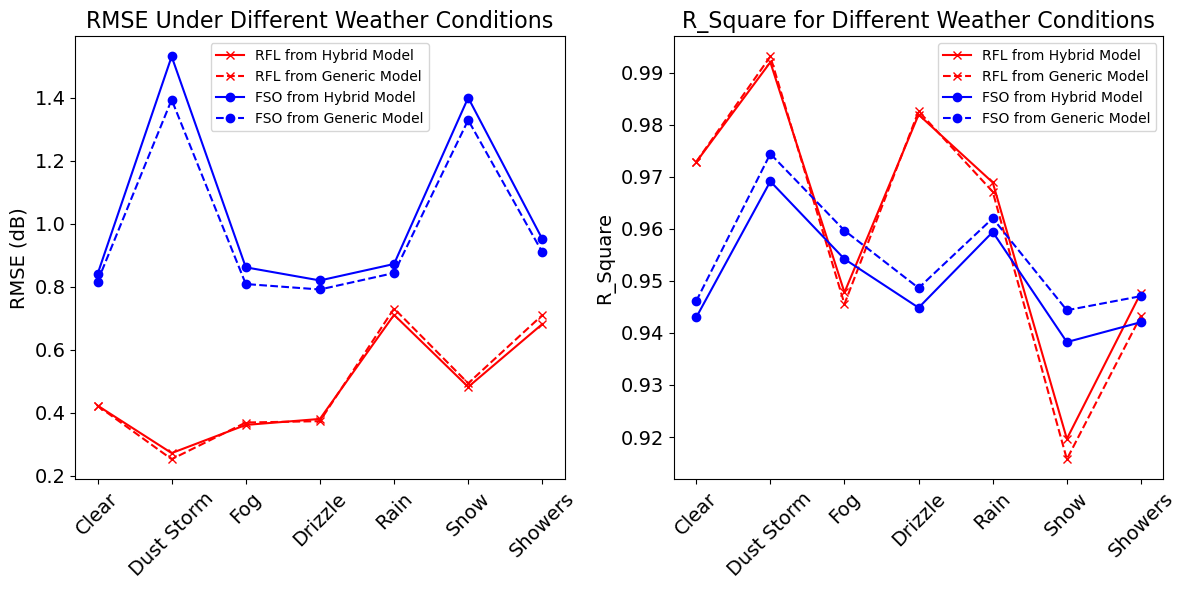

In [ ]:
weather_list = ["Clear","Dust Storm","Fog","Drizzle","Rain","Snow","Showers"]
synop_codes = [0, 3, 4, 5, 6, 7, 8]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  

plt.plot(weather_list, RFL_hybrid_rmse_list, color='r', marker='x', label='RFL from Hybrid Model')
plt.plot(weather_list, RFL_generic_rmse_list, color='r',  marker='x', linestyle='--', label='RFL from Generic Model')
plt.plot(weather_list, FSO_hybrid_rmse_list, color='b', marker='o', label='FSO from Hybrid Model')
plt.plot(weather_list, FSO_generic_rmse_list, color='b', marker='o', linestyle='--', label='FSO from Generic Model')

plt.ylabel('RMSE (dB)', fontsize = 14)
plt.title('RMSE Under Different Weather Conditions', fontsize = 16)
plt.xticks(rotation=45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()

# Create the second subplot
plt.subplot(1, 2, 2) 

plt.plot(weather_list, RFL_hybrid_r2_list, color='r', marker='x', label='RFL from Hybrid Model')
plt.plot(weather_list, RFL_generic_r2_list, color='r',  marker='x', linestyle='--', label='RFL from Generic Model')
plt.plot(weather_list, FSO_hybrid_r2_list, color='b', marker='o', label='FSO from Hybrid Model')
plt.plot(weather_list, FSO_generic_r2_list, color='b', marker='o', linestyle='--', label='FSO from Generic Model')


plt.ylabel('R_Square', fontsize = 14)
plt.title('R_Square for Different Weather Conditions', fontsize = 16)
plt.xticks(rotation=45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()  

plt.tight_layout()
plt.show()